<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/main/AORC_smet.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AORC → SMET Converter

Hourly workflow that pulls NOAA's AORC 1 km retrospective forcing from the public AWS bucket, blends in SNODAS snow depths for HS, and writes SNOWPACK-ready SMET files with both shortwave (ISWR) and longwave (ILWR) radiation.

<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/main/AORC_smet.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AORC → SMET Converter

Hourly workflow that pulls NOAA's AORC 1 km retrospective forcing from the public AWS bucket, blends in SNODAS snow depths for HS, and writes SNOWPACK-ready SMET files with both shortwave (ISWR) and longwave (ILWR) radiation.

## Setup & Installation

In [23]:
# Install packages (if not already installed)
%pip install -q s3fs xarray h5netcdf pandas numpy matplotlib tqdm

import sys
import warnings
warnings.filterwarnings('ignore')

IN_COLAB = "google.colab" in sys.modules
%matplotlib inline

import os
import math
import struct
import tarfile
import gzip
import urllib.request
import urllib.error
from io import BytesIO
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import s3fs

s3_fs = s3fs.S3FileSystem(anon=True)

print("✓ Environment ready - core libraries imported")

Note: you may need to restart the kernel to use updated packages.
✓ Environment ready - core libraries imported


## Configuration


In [24]:
# ============================================
# USER INPUT: Edit these values
# ============================================

latitude = 39.5261    # Vail Pass, Colorado
longitude = -106.2131  # Vail Pass, Colorado
altitude = 3231.0      # Station altitude in meters
station_id = "VAIL_PASS_CO"  # Station identifier

# Date range (format: YYYY-MM-DD)
start_date = os.environ.get("AORC_START_DATE", "2023-10-01")
end_date = os.environ.get("AORC_END_DATE", "2024-04-30")

start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date)
duration_days = (end_dt - start_dt).days + 1
hours_requested = duration_days * 24

print(f"✓ Configuration:")
print(f"  Location: {latitude}°N, {longitude}°E")
print(f"  Altitude: {altitude} m")
print(f"  Station: {station_id}")
print(f"  Period: {start_date} to {end_date} ({duration_days} days, {hours_requested} hours)")


✓ Configuration:
  Location: 39.5261°N, -106.2131°E
  Altitude: 3231.0 m
  Station: VAIL_PASS_CO
  Period: 2023-10-01 to 2024-04-30 (213 days, 5112 hours)


## AORC Data Utilities


In [25]:
# Helper functions for efficient point sampling of the AORC grid

AORC_BUCKET = "noaa-nws-aorc-v1-1-1km"
AORC_VARIABLES = [
    "TMP_2maboveground",  # Air temperature (K)
    "SPFH_2maboveground",  # Specific humidity (kg/kg)
    "UGRD_10maboveground", # Zonal wind (m/s)
    "VGRD_10maboveground", # Meridional wind (m/s)
    "DSWRF_surface",      # Downward shortwave (W/m²)
    "DLWRF_surface",      # Downward longwave (W/m²)
    "APCP_surface"        # Accumulated precip (kg/m² = mm)
]
PRESSURE_CANDIDATES = ["PRES_surface", "PSFC_surface", "PRES"]

def compute_relative_humidity(temp_k, specific_humidity, pressure_pa):
    temp_c = temp_k - 273.15
    es = 6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * 100.0
    es = np.maximum(es, 1.0)
    e = (specific_humidity * pressure_pa) / (0.622 + 0.378 * specific_humidity)
    rh = np.clip(e / es, 0.0, 1.0)
    return rh

def wind_from_components(u, v):
    speed = np.sqrt(u ** 2 + v ** 2)
    direction = (270.0 - np.degrees(np.arctan2(v, u))) % 360.0
    return speed, direction

def cumulative_to_hourly(values):
    arr = np.asarray(values, dtype=float)
    increments = np.diff(arr, prepend=np.nan)
    increments[np.isnan(increments)] = arr[0]
    resets = increments < 0
    increments[resets] = arr[resets]
    return np.clip(increments, 0.0, None)

def _detect_pressure_var(dataset):
    for candidate in PRESSURE_CANDIDATES:
        if candidate in dataset.data_vars:
            return candidate
    return None

def fetch_aorc_point_series(lat, lon, start_dt, end_dt, verbose=True):
    frames = []
    missing_years = []
    selected_lat = np.nan
    selected_lon = np.nan
    pressure_var = None

    years = range(start_dt.year, end_dt.year + 1)
    for year in years:
        year_start = pd.Timestamp(f"{year}-01-01 00:00:00")
        year_end = pd.Timestamp(f"{year}-12-31 23:00:00")
        slice_start = max(start_dt, year_start)
        slice_end = min(end_dt, year_end)
        if slice_start > slice_end:
            continue

        store_path = f"{AORC_BUCKET}/{year}.zarr"
        if not s3_fs.exists(store_path):
            missing_years.append(year)
            if verbose:
                print(f"[{year}] ✗ Missing store ({store_path})")
            continue

        if verbose:
            print(f"[{year}] Loading {store_path} ... ", end="")

        mapper = s3_fs.get_mapper(store_path)
        ds = xr.open_zarr(mapper, consolidated=True)
        try:
            if pressure_var is None:
                pressure_var = _detect_pressure_var(ds)
                if pressure_var is None:
                    raise KeyError("Surface pressure variable not found in AORC dataset.")

            vars_to_pull = [v for v in AORC_VARIABLES if v in ds.data_vars]
            if pressure_var not in vars_to_pull:
                vars_to_pull.append(pressure_var)

            subset = ds[vars_to_pull].sel(time=slice(slice_start, slice_end))
            if subset.time.size == 0:
                if verbose:
                    print("no samples in range")
                continue

            point = subset.sel(latitude=lat, longitude=lon, method='nearest').load()
            selected_lat = float(point.latitude.values)
            selected_lon = float(point.longitude.values)
            frames.append(point.to_dataframe().reset_index())
            if verbose:
                print(f"✓ {subset.time.size} hours at {selected_lat:.3f}°, {selected_lon:.3f}°")
        finally:
            ds.close()

    if not frames:
        raise RuntimeError(f"No AORC data retrieved for {start_dt.date()} to {end_dt.date()}. Missing years: {missing_years or 'none'}")

    raw_df = pd.concat(frames, ignore_index=True)
    metadata = {
        "pressure_var": pressure_var,
        "selected_lat": selected_lat,
        "selected_lon": selected_lon,
        "missing_years": missing_years,
        "total_records": len(raw_df)
    }
    return raw_df, metadata

print("✓ AORC helper functions ready")


✓ AORC helper functions ready


## Fetch AORC Data


In [26]:
print("Fetching AORC hourly forcing...")
raw_df, metadata = fetch_aorc_point_series(latitude, longitude, start_dt, end_dt, verbose=True)

raw_df['time'] = pd.to_datetime(raw_df['time'], utc=True)
start_ts = start_dt.tz_localize('UTC')
end_ts = (end_dt + pd.Timedelta(hours=23)).tz_localize('UTC')

pressure = raw_df[metadata['pressure_var']].to_numpy()
temperature = raw_df['TMP_2maboveground'].to_numpy()
specific_humidity = raw_df['SPFH_2maboveground'].to_numpy()
u_wind = raw_df['UGRD_10maboveground'].to_numpy()
v_wind = raw_df['VGRD_10maboveground'].to_numpy()
shortwave = raw_df['DSWRF_surface'].to_numpy()
longwave = raw_df['DLWRF_surface'].to_numpy()
precip_cumulative = raw_df['APCP_surface'].to_numpy()

relative_humidity = compute_relative_humidity(temperature, specific_humidity, pressure)
wind_speed, wind_dir = wind_from_components(u_wind, v_wind)
precip_hourly = cumulative_to_hourly(precip_cumulative)


df = pd.DataFrame({
    'timestamp': raw_df['time'],
    'temperature_2m': temperature,
    'relative_humidity_2m': relative_humidity,
    'wind_speed_10m': wind_speed,
    'wind_direction_10m': wind_dir,
    'shortwave_radiation': shortwave,
    'longwave_radiation': longwave,
    'precipitation': precip_hourly,
})

df = df[(df['timestamp'] >= start_ts) & (df['timestamp'] <= end_ts)].sort_values('timestamp').reset_index(drop=True)
df['snow_depth'] = np.nan  # will be filled by SNODAS later

print(f"✓ Retrieved {len(df)} hourly records")
print(f"  Selected grid cell: {metadata['selected_lat']:.4f}°N, {metadata['selected_lon']:.4f}°E")
print(f"  Pressure field: {metadata['pressure_var']}")
if metadata['missing_years']:
    print(f"  ⚠ Missing years (not downloaded): {metadata['missing_years']}")


Fetching AORC hourly forcing...


[2023] Loading noaa-nws-aorc-v1-1-1km/2023.zarr ... ✓ 2208 hours at 39.524°, -106.209°
[2024] Loading noaa-nws-aorc-v1-1-1km/2024.zarr ... ✓ 2881 hours at 39.524°, -106.209°
✓ Retrieved 5089 hourly records
  Selected grid cell: 39.5242°N, -106.2093°E
  Pressure field: PRES_surface


## SNODAS Snow Depth Integration

In [27]:
# SNODAS function (simplified - only shows errors when debug=False)

def get_snodas_snow_depth(lat, lon, date_str, cache_dir="snodas_cache", debug=False):

    """Download and extract SNODAS snow depth from NSIDC."""

    SNODAS_NODATA = -9999

    # Grid configurations (detected from file size)
    GRID_CONFIGS = {
        'old': {'XMIN': -124.73375000000000, 'YMAX': 52.87458333333333,
                'XMAX': -66.94208333333333, 'YMIN': 24.94958333333333,
                'NCOLS': 6935, 'NROWS': 3351, 'name': 'Pre-Oct-2013'},
        'new': {'XMIN': -124.73333333333333, 'YMAX': 52.87500000000000,
                'XMAX': -66.94166666666667, 'YMIN': 24.95000000000000,
                'NCOLS': 3353, 'NROWS': 3353, 'name': 'Post-Oct-2013'}
    }

    # Check location bounds
    if lat < 24.95 or lat > 52.88 or lon < -124.74 or lon > -66.94:
        return None

    # Construct URL
    tar_filename = f"SNODAS_{date_str}.tar"
    data_base = "https://noaadata.apps.nsidc.org/NOAA/G02158/masked"
    year = date_str[:4]
    month = date_str[4:6]
    month_names = ["01_Jan", "02_Feb", "03_Mar", "04_Apr", "05_May", "06_Jun",
                   "07_Jul", "08_Aug", "09_Sep", "10_Oct", "11_Nov", "12_Dec"]
    month_dir = month_names[int(month) - 1]
    data_url = f"{data_base}/{year}/{month_dir}/{tar_filename}"

    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, tar_filename)

    try:
        # Download or use cache
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                tar_data = BytesIO(f.read())
        else:
            if debug:
                print(f"  Downloading {date_str}...")
            with urllib.request.urlopen(data_url, timeout=60) as response:
                tar_data = BytesIO(response.read())
                with open(cache_path, 'wb') as f:
                    f.write(tar_data.getvalue())
            tar_data.seek(0)

        # Extract and decompress
        with tarfile.open(fileobj=tar_data, mode='r') as tar:
            for member in tar.getmembers():
                if '1036' in member.name and member.name.endswith('.dat.gz'):
                    snow_depth_gz_file = tar.extractfile(member)
                    break
            else:
                return None

        with gzip.open(snow_depth_gz_file, 'rb') as gz_file:
            data = gz_file.read()

        # Detect grid from file size
        num_values = len(data) // 2
        grid_config = None
        for config in GRID_CONFIGS.values():
            if num_values == config['NCOLS'] * config['NROWS']:
                grid_config = config
                break

        if grid_config is None:
            return None

        # Parse binary data
        SNODAS_NCOLS = grid_config['NCOLS']
        SNODAS_NROWS = grid_config['NROWS']
        values = struct.unpack(f">{SNODAS_NCOLS * SNODAS_NROWS}h", data)
        snow_depth_array = np.array(values).reshape((SNODAS_NROWS, SNODAS_NCOLS))

        # Calculate grid coordinates
        SNODAS_XMIN = grid_config['XMIN']
        SNODAS_YMAX = grid_config['YMAX']
        SNODAS_CELLSIZE_X = (grid_config['XMAX'] - SNODAS_XMIN) / SNODAS_NCOLS
        SNODAS_CELLSIZE_Y = (SNODAS_YMAX - grid_config['YMIN']) / SNODAS_NROWS

        col = int((lon - SNODAS_XMIN) / SNODAS_CELLSIZE_X)
        row = int((SNODAS_YMAX - lat) / SNODAS_CELLSIZE_Y)
        col = max(0, min(SNODAS_NCOLS - 1, col))
        row = max(0, min(SNODAS_NROWS - 1, row))

        # Extract value
        snow_depth_raw = snow_depth_array[row, col]
        if snow_depth_raw == SNODAS_NODATA or snow_depth_raw < 0:
            return None

        snow_depth_m = snow_depth_raw / 1000.0
        return snow_depth_m if snow_depth_m >= 0.01 else 0.0

    except Exception as e:
        if debug:
            print(f"  Error: {e}")
        return None


print("✓ SNODAS function ready")

✓ SNODAS function ready


In [28]:
# Download SNODAS snow depth data and inject into the forcing dataframe
print("Downloading SNODAS snow depth data...")
print(f"Location: {latitude}°N, {longitude}°E | Date range: {start_date} to {end_date}")

snodas_hours_replaced = 0

if latitude < 24.95 or latitude > 52.83 or longitude < -124.73 or longitude > -66.95:
    print("⚠ Location outside SNODAS coverage. HS will remain zero.")
    use_snodas = False
else:
    use_snodas = True
    snodas_snow_depth = {}
    failed_dates = []

    all_dates = []
    current_date = start_dt
    while current_date <= end_dt:
        all_dates.append(current_date)
        current_date += timedelta(days=1)

    total_dates = len(all_dates)
    print(f"Processing {total_dates} days...")

    if len(all_dates) > 0:
        test_date_str = all_dates[0].strftime("%Y%m%d")
        print(f"\n🔍 Testing first date ({test_date_str})...")
        test_result = get_snodas_snow_depth(latitude, longitude, test_date_str, debug=True)
        print(f"Result: {test_result}\n")

    for idx, current_date in enumerate(all_dates, 1):
        date_str = current_date.strftime("%Y%m%d")
        progress = (idx / total_dates) * 100

        print(f"[{idx:3d}/{total_dates}] ({progress:5.1f}%) {date_str}... ", end="", flush=True)

        try:
            snow_depth = get_snodas_snow_depth(latitude, longitude, date_str, debug=False)
            if snow_depth is not None:
                snodas_snow_depth[date_str] = snow_depth
                print(f"✓ {snow_depth:.3f} m")
            else:
                failed_dates.append(date_str)
                print("✗ No data")
        except Exception:
            failed_dates.append(date_str)
            print("✗ Error")

    if len(snodas_snow_depth) == 0:
        print("\n⚠ No SNODAS data available. HS will stay at zero.")
        use_snodas = False
    else:
        print(f"\n✓ Retrieved SNODAS snow depth for {len(snodas_snow_depth)}/{total_dates} days")
        if len(failed_dates) > 0:
            print(f"⚠ {len(failed_dates)} dates failed")

        replaced_count = 0
        for idx, row in df.iterrows():
            date_str = row['timestamp'].strftime("%Y%m%d")
            if date_str in snodas_snow_depth:
                df.at[idx, 'snow_depth'] = snodas_snow_depth[date_str] * 1000.0  # mm
                replaced_count += 1
        snodas_hours_replaced = replaced_count
        print(f"✓ Replaced HS values for {replaced_count} hourly records")

if not use_snodas:
    df['snow_depth'] = df['snow_depth'].fillna(0.0)
    print("\nNote: HS filled with zeros because SNODAS data was unavailable.")
else:
    remaining = df['snow_depth'].isna().sum()
    if remaining > 0:
        df['snow_depth'] = df['snow_depth'].fillna(0.0)
        print(f"⚠ {remaining} hours missing SNODAS values were filled with zeros.")


Location: 39.5261°N, -106.2131°E | Date range: 2023-10-01 to 2024-04-30
Processing 213 days...

🔍 Testing first date (20231001)...
Result: 0.0

[  1/213] (  0.5%) 20231001... ✓ 0.000 m
[  2/213] (  0.9%) 20231002... ✓ 0.000 m
[  3/213] (  1.4%) 20231003... ✓ 0.021 m
[  4/213] (  1.9%) 20231004... ✓ 0.014 m
[  5/213] (  2.3%) 20231005... ✓ 0.000 m
[  6/213] (  2.8%) 20231006... ✓ 0.000 m
[  7/213] (  3.3%) 20231007... ✓ 0.000 m
[  8/213] (  3.8%) 20231008... ✓ 0.000 m
[  9/213] (  4.2%) 20231009... ✓ 0.000 m
[ 10/213] (  4.7%) 20231010... ✓ 0.000 m
[ 11/213] (  5.2%) 20231011... ✓ 0.000 m
[ 12/213] (  5.6%) 20231012... ✓ 0.047 m
[ 13/213] (  6.1%) 20231013... ✓ 0.223 m
[ 14/213] (  6.6%) 20231014... ✓ 0.191 m
[ 15/213] (  7.0%) 20231015... ✓ 0.170 m
[ 16/213] (  7.5%) 20231016... ✓ 0.140 m
[ 17/213] (  8.0%) 20231017... ✓ 0.048 m
[ 18/213] (  8.5%) 20231018... ✓ 0.000 m
[ 19/213] (  8.9%) 20231019... ✓ 0.000 m
[ 20/213] (  9.4%) 20231020... ✓ 0.000 m
[ 21/213] (  9.9%) 20231021... ✓ 0.0

In [29]:
# Convert to SMET format with ILWR included
print("Converting data to SMET format...")

smet_df = pd.DataFrame()
smet_df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%S')
smet_df['TA'] = df['temperature_2m']
smet_df['RH'] = df['relative_humidity_2m']
smet_df['VW'] = df['wind_speed_10m']
smet_df['DW'] = df['wind_direction_10m']

if use_snodas and snodas_hours_replaced > 0:
    smet_df['HS'] = df['snow_depth'] / 1000.0
    print(f"  ✓ Using SNODAS snow depth ({snodas_hours_replaced} hourly samples)")
else:
    smet_df['HS'] = df['snow_depth'].fillna(0.0) / 1000.0
    print("  ⚠ SNODAS unavailable - HS values are zeros")

smet_df['ISWR'] = df['shortwave_radiation']
smet_df['ILWR'] = df['longwave_radiation']
smet_df['PSUM'] = df['precipitation']

nodata_value = -999
smet_df = smet_df.fillna(nodata_value)

numeric_cols = ['TA', 'RH', 'VW', 'DW', 'HS', 'ISWR', 'ILWR', 'PSUM']
for col in numeric_cols:
    smet_df[col] = pd.to_numeric(smet_df[col], errors='coerce').fillna(nodata_value)

print(f"✓ Data converted to SMET format")
print(f"  Records: {len(smet_df)}")

fields = ['timestamp', 'TA', 'RH', 'VW', 'DW', 'HS', 'ISWR', 'ILWR', 'PSUM']
smet_filename = f"{station_id}_aorc_{start_date}_{end_date}.smet"

with open(smet_filename, 'w') as f:
    f.write('SMET 1.2 ASCII\n')
    f.write('[HEADER]\n')
    f.write(f"station_id = {station_id}\n")
    f.write(f"latitude = {latitude:.10f}\n")
    f.write(f"longitude = {longitude:.10f}\n")
    f.write(f"altitude = {altitude:.2f}\n")
    f.write(f"nodata = {nodata_value}\n")
    f.write('tz = 0\n')
    f.write(f"fields = {' '.join(fields)}\n")
    f.write('[DATA]\n')

    for _, row in smet_df.iterrows():
        values = []
        for field in fields:
            val = row[field]
            if field == 'timestamp':
                values.append(str(val))
            else:
                values.append(f"{nodata_value}" if pd.isna(val) or val == nodata_value else f"{val:.2f}")
        f.write('\t'.join(values) + '\n')

file_size = os.path.getsize(smet_filename)
print(f"\n✓ SMET file written: {smet_filename}")
print(f"  File size: {file_size/1024:.2f} KB")
print(f"\nFirst few records:")
print(smet_df.head())
print(f"\nData summary:")
print(smet_df[numeric_cols].describe())


Converting data to SMET format...
  ✓ Using SNODAS snow depth (5089 hourly samples)
✓ Data converted to SMET format
  Records: 5089

✓ SMET file written: VAIL_PASS_CO_aorc_2023-10-01_2024-04-30.smet
  File size: 331.99 KB

First few records:
             timestamp          TA        RH        VW          DW   HS  \
0  2023-10-01T00:00:00  285.500004  0.392799  3.100000  180.000000  0.0   
1  2023-10-01T01:00:00  283.900004  0.368440  3.041381  207.407575  0.0   
2  2023-10-01T02:00:00  282.600004  0.430381  7.100704  179.193071  0.0   
3  2023-10-01T03:00:00  281.600004  0.520158  3.535534  188.130102  0.0   
4  2023-10-01T04:00:00  281.400004  0.537682  3.178050  167.275644  0.0   

        ISWR        ILWR  PSUM  
0  92.300001  265.400004   0.0  
1   0.000000  265.400004   0.0  
2   0.000000  265.300004   0.0  
3   0.000000  254.600004   0.0  
4   0.000000  254.600004   0.0  

Data summary:
                TA           RH           VW           DW           HS  \
count  5089.000000  

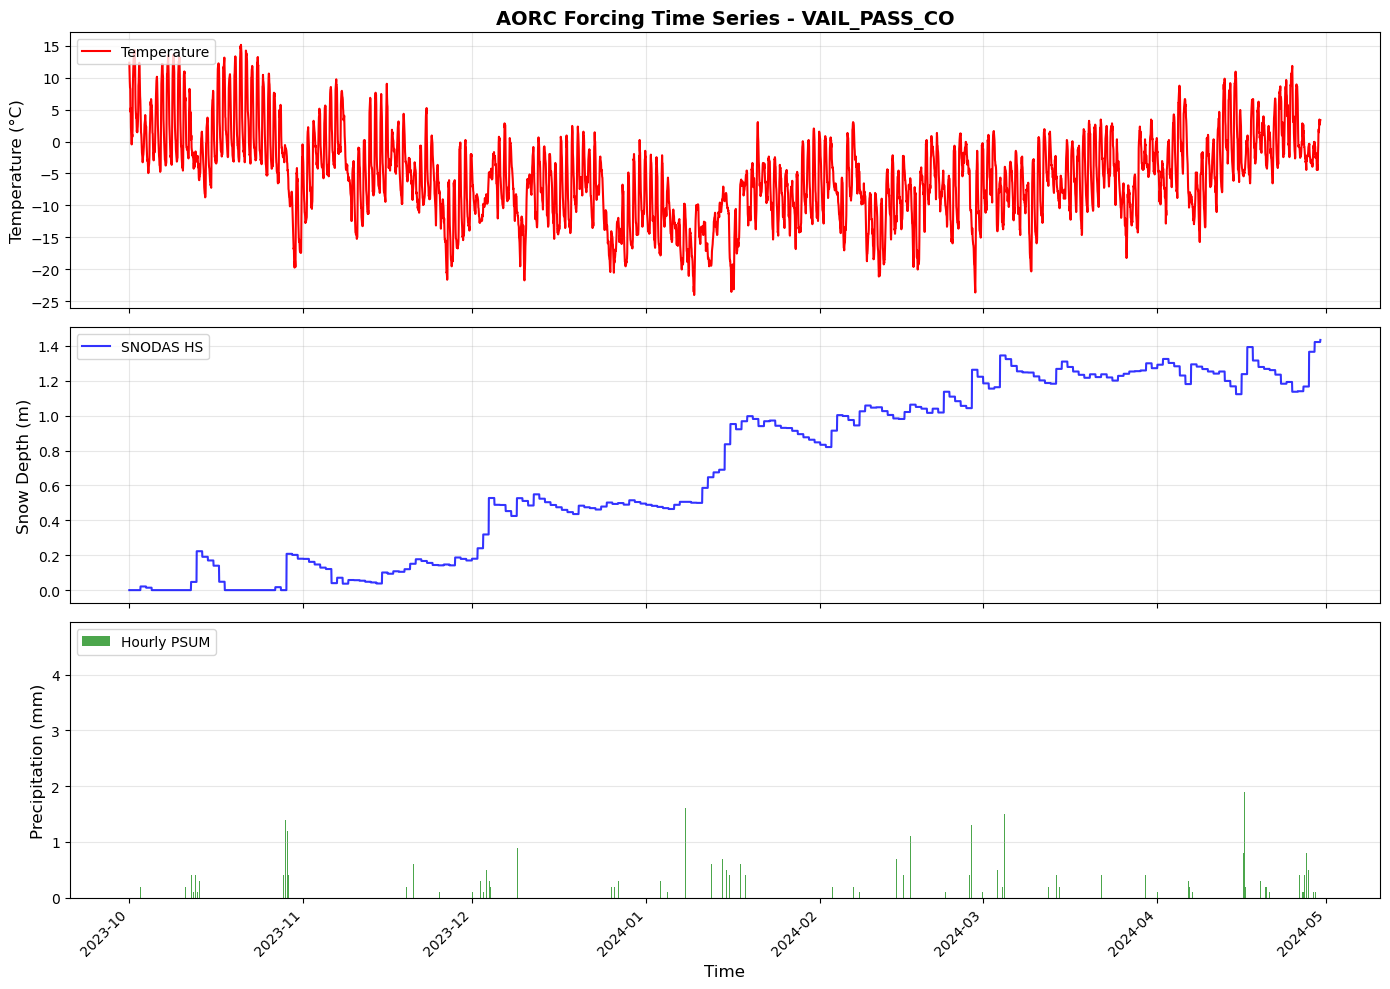

✓ Time series plots created
  Snow depth range: 0.000 - 1.434 m


In [30]:
# Primary time series plots
plot_df = smet_df.copy()
plot_df['timestamp'] = pd.to_datetime(plot_df['timestamp'])

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ax1 = axes[0]
ax1.plot(plot_df['timestamp'], plot_df['TA'] - 273.15, color='red', linewidth=1.5, label='Temperature')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(f'AORC Forcing Time Series - {station_id}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

ax2 = axes[1]
ax2.plot(plot_df['timestamp'], plot_df['HS'], color='blue', linewidth=1.5, label='SNODAS HS', alpha=0.8)
ax2.set_ylabel('Snow Depth (m)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

ax3 = axes[2]
ax3.bar(plot_df['timestamp'], plot_df['PSUM'], color='green', alpha=0.7, width=0.03, label='Hourly PSUM')
ax3.set_ylabel('Precipitation (mm)', fontsize=12)
ax3.set_xlabel('Time', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(loc='upper left')

plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('✓ Time series plots created')
print(f"  Snow depth range: {plot_df['HS'].min():.3f} - {plot_df['HS'].max():.3f} m")

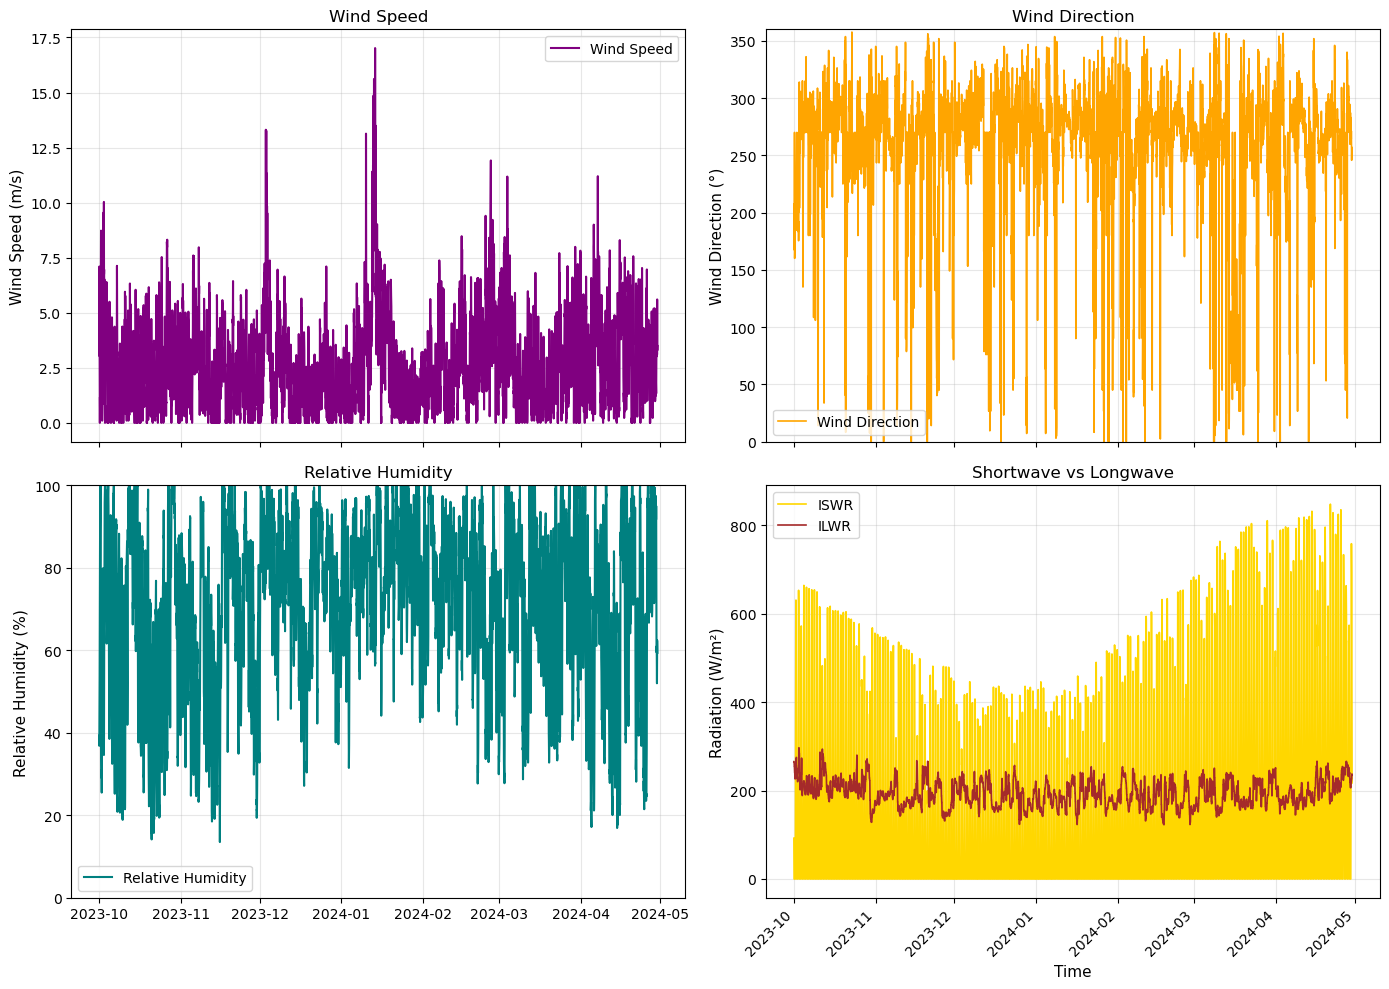

✓ Additional plots created


In [31]:
# Additional diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

ax1 = axes[0, 0]
ax1.plot(plot_df['timestamp'], plot_df['VW'], color='purple', linewidth=1.5, label='Wind Speed')
ax1.set_ylabel('Wind Speed (m/s)', fontsize=11)
ax1.set_title('Wind Speed', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2 = axes[0, 1]
ax2.plot(plot_df['timestamp'], plot_df['DW'], color='orange', linewidth=1.2, label='Wind Direction')
ax2.set_ylabel('Wind Direction (°)', fontsize=11)
ax2.set_title('Wind Direction', fontsize=12)
ax2.set_ylim(0, 360)
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3 = axes[1, 0]
ax3.plot(plot_df['timestamp'], plot_df['RH'] * 100, color='teal', linewidth=1.5, label='Relative Humidity')
ax3.set_ylabel('Relative Humidity (%)', fontsize=11)
ax3.set_title('Relative Humidity', fontsize=12)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)
ax3.legend()

ax4 = axes[1, 1]
ax4.plot(plot_df['timestamp'], plot_df['ISWR'], color='gold', linewidth=1.2, label='ISWR')
ax4.plot(plot_df['timestamp'], plot_df['ILWR'], color='brown', linewidth=1.2, label='ILWR')
ax4.set_ylabel('Radiation (W/m²)', fontsize=11)
ax4.set_title('Shortwave vs Longwave', fontsize=12)
ax4.set_xlabel('Time', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('✓ Additional plots created')

## Summary

- Fields in SMET: timestamp, TA, RH, VW, DW, HS (SNODAS), ISWR, ILWR, PSUM
- HS (snow depth) sourced from SNODAS daily tarballs and converted to meters
- PSUM represents hourly precipitation increments derived from the cumulative AORC field
- ILWR (downward longwave) is now written alongside ISWR for full-radiation forcing